In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [42]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
      training data
    y : ndarray, shape (n_samples, 1)
      Label of training data
    batch_size : int
      batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int64)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [43]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    A Simple three-layer neural network classifier
    Parameters
    ----------
    Attributes
    ----------
    """

    def __init__(self, n_epoch = 50, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10,
                sigma = 0.01, n_batch = 20, activation_function = 'tanh', learning_rate = 0.01, verbose = True):
        # Record hyperparameters as attributes
        self.verbose = verbose
        self.n_epoch = n_epoch
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.n_batch = n_batch
        self.activate_function = activation_function
        self.lr = learning_rate

    def initial_weight(self):
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.b1 = np.zeros(self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.b2 = np.zeros(self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.b3 = np.zeros(self.n_output)

    def activation_function(self, X):
        if self.activate_function == 'sigmoid':
            return 1/(1 + np.exp(-X))
        elif self.activate_function == 'relu':
            return np.max(0.0, X)
        elif self.activate_function == 'tanh':
            return np.tanh(X)

    def softmax(self, X):
        return np.exp(X - np.max(X))/np.sum(np.exp(X-np.max(X)), axis = 1, keepdims= True)

    def loss_function(self, y, yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y + delta))

    def gradient_descent(self, X, y, yt):
        '''
        Calculate gradient descent
        '''
        # 3rd layer
        delta_a3 = (y-yt)/self.n_batch
        delta_b3 = np.sum(delta_a3, axis = 0)
        delta_W3 = np.dot(self.z2.T, delta_a3)
        delta_z2 = np.dot(delta_a3, self.W3.T)


        self.W3 -= self.lr * delta_W3
        self.b3 -= self.lr * delta_b3

        # 2nd layer
        if self.activate_function == 'sigmoid':
            delta_a2 = delta_z2 * (1-self.activation_function(self.z2))*self.activation_function(self.z2)
        elif self.activate_function == 'tanh':
            delta_a2 = delta_z2*(np.tanh(self.z2)**2)

        delta_b2 = np.sum(delta_a2, axis = 0)
        delta_W2 = np.dot(self.z1.T, delta_a2)
        delta_z1 = np.dot(delta_a2, self.W2.T)

        self.W2 -= self.lr * delta_W2
        self.b2 -= self.lr * delta_b2

        # 1st layer
        if self.activate_function == 'sigmoid':
            delta_a1 = delta_z1 * (1-self.activation_function(self.z1))*self.activation_function(self.z1)
        elif self.activate_function == 'tanh':
            delta_a1 = delta_z1*(np.tanh(self.z1)**2)

        delta_b1 = np.sum(delta_a1, axis = 0)
        delta_W1 = np.dot(X.T, delta_a1)

        self.W1 -= self.lr * delta_W1
        self.b1 -= self.lr * delta_b1


    def fit(self, X, y, X_val=None, y_val=None):
        """
        Train a neural network classifier.
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Features of training data
        y : ndarray, shape (n_samples, )
            Label of training data
        X_val : ndarray, shape (n_samples, n_features)
            Features of validation data
        y_val : ndarray, shape (n_samples, )
            Label of validation data
        """
        # initialize weights
        self.initial_weight()

        # the loss function for each epoch
        self.log_loss = []
        self.log_loss_val = []

        self.log_acc = []
        self.log_acc_val = []

        for epoch in range(self.n_epoch):
            get_mini_batch = GetMiniBatch(X, y , batch_size = self.n_batch)
            self.loss = 0
            self.true_y = np.array([])
            self.pred_y = np.array([])

            for mini_X_train , mini_y_train in get_mini_batch:
                #1st layer
                self.z1 = self.activation_function(np.dot(mini_X_train, self.W1) + self.b1)

                #2nd layer
                self.z2 = self.activation_function(np.dot(self.z1, self.W2) + self.b2)

                #3rd layer
                yhat = self.softmax(np.dot(self.z2, self.W3) + self.b3)

                #backpropagation
                self.gradient_descent(mini_X_train, yhat, mini_y_train)

                #record correct and estimated values for mini batch data
                self.true_y = np.concatenate([self.true_y, np.argmax(mini_y_train, axis = 1)])
                self.pred_y = np.concatenate([self.pred_y, np.argmax(yhat, axis = 1)])

                # Loss function
                self.loss += self.loss_function(yhat, mini_y_train)

            # record loss function for each epoch
            self.log_loss.append(self.loss/len(get_mini_batch))

            #Accuracy
            acc = accuracy_score(self.true_y, self.pred_y)
            self.log_acc.append(acc)

            if (type(X_val) != bool):
                self.z1_val = self.activation_function(np.dot(X_val, self.W1) + self.b1)
                self.z2_val = self.activation_function(np.dot(self.z1_val, self.W2) + self.b2)
                yhat_val = self.softmax(np.dot(self.z2_val, self.W3) + self.b3)

                #loss function
                self.loss_val = self.loss_function(yhat_val, y_val)
                self.log_loss_val.append(self.loss_val)

                acc_val = accuracy_score(np.argmax(y_val, axis = 1), np.argmax(yhat_val, axis = 1))
                self.log_acc_val.append(acc_val)

            if self.verbose:
                print('epoch:{} loss:{} acc:{}'.format(epoch, self.loss/self.n_batch, acc))

    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            training sample
        Returns
        -------
        pred:    ndarray, shape (n_samples, 1)
            predicted result
        """

        self.pred_z1 = self.activation_function(np.dot(X, self.W1) + self.b1)
        self.pred_z2 = self.activation_function(np.dot(self.pred_z1, self.W2) + self.b2)
        pred = np.argmax(np.dot(self.pred_z2, self.W3) + self.b3, axis=1)
        return pred

In [44]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [45]:
X_train.shape

(60000, 28, 28)

In [46]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [47]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [48]:
X_test.shape

(10000, 784)

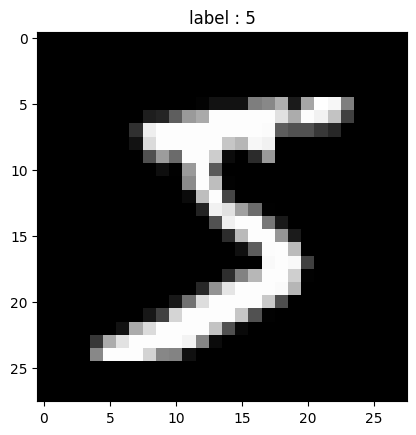

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

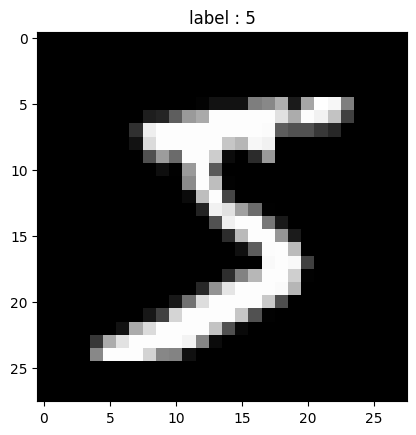

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

In [50]:
import numpy as np

index = 0
image = X_train[index].reshape(28,28)

image = image.astype(float) # Convert to float type

image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # 値を確認

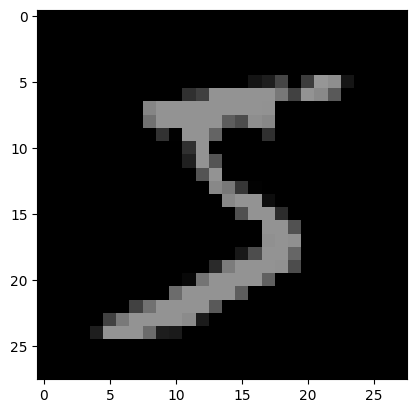

In [51]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

In [52]:
X_train = X_train.astype(float)  # Convert to float type
X_test = X_test.astype(float)    # Convert to float type
X_train /= 255                    # Normalize
X_test /= 255                     # Normalize
print(X_train.max())              # Check max value (should be 1.0)
print(X_train.min())              # Check min value (should be 0.0)


1.0
0.0


In [53]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64
print(y_train_one_hot[0])

(60000,)
(60000, 10)
float64
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)


(48000, 784)
(12000, 784)


In [55]:
n_features = 784
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1)
# W1: (784, 400) 313600
print(W1)

[[ 0.00961856  0.00376688 -0.01863506 ... -0.00360374  0.00398467
  -0.00407732]
 [ 0.0135541   0.00235639 -0.00217422 ... -0.00488015  0.00114373
   0.00035158]
 [-0.00206121 -0.00720453 -0.01836603 ...  0.01322278 -0.00819252
  -0.01090792]
 ...
 [-0.01159296 -0.00759025 -0.00303539 ... -0.00931775  0.00367186
   0.0004025 ]
 [ 0.01669432 -0.00466418  0.01498928 ...  0.0128712  -0.0122659
  -0.01283277]
 [-0.00074953 -0.01561221 -0.00287403 ...  0.00015798 -0.00643437
   0.00146577]]


In [56]:
n_output = 10
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
W2 = sigma * np.random.randn(n_output, n_nodes1)
# W2: (10, 400) 4000
print(W2)

[[-0.01061989 -0.00046799  0.00970675 ...  0.01232747 -0.00088416
  -0.01342615]
 [ 0.00458898 -0.00106353  0.00816854 ...  0.00078517  0.00124
  -0.01117265]
 [ 0.00344981 -0.00206698  0.01159646 ... -0.00256783 -0.00689653
  -0.00460941]
 ...
 [-0.01998769 -0.00932978  0.00030799 ...  0.00124898  0.01058473
   0.00310414]
 [-0.00079804 -0.00268841  0.00053616 ... -0.00097225 -0.00827755
  -0.00393807]
 [ 0.01211369 -0.0029224   0.00138221 ...  0.00356658 -0.00021342
   0.00613771]]


In [57]:
batch_size = 20 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）

In [58]:
X_train.shape
y_train_one_hot.shape
X_val.shape
y_val_one_hot.shape

(10000, 10)

In [59]:
print(X_val.shape)
print(y_val_one_hot.shape)

(12000, 784)
(10000, 10)


In [60]:
clf = ScratchSimpleNeuralNetrowkClassifier(n_epoch = 25, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10,
                sigma = 0.01, n_batch = 20, activation_function = 'tanh', learning_rate = 0.01, verbose = True)
clf.fit(X_train, y_train, X_val, y_val)
y_pred = clf.predict(X_val)
print(y_pred)

epoch:0 loss:27.49290750565935 acc:0.11616666666666667
epoch:1 loss:27.238950761635834 acc:0.1583125
epoch:2 loss:26.98576579713809 acc:0.26897916666666666
epoch:3 loss:26.72577702065455 acc:0.39475
epoch:4 loss:26.45191359715554 acc:0.489625
epoch:5 loss:26.14852962578174 acc:0.5596041666666667
epoch:6 loss:25.748579399785104 acc:0.6119791666666666
epoch:7 loss:25.134252427481293 acc:0.532375
epoch:8 loss:24.194945773742514 acc:0.4666875
epoch:9 loss:22.991933764566845 acc:0.51925
epoch:10 loss:16.937156102141653 acc:0.49977083333333333
epoch:11 loss:12.5642665817056 acc:0.6344166666666666
epoch:12 loss:10.664514085247784 acc:0.6956041666666667
epoch:13 loss:9.841425995025915 acc:0.7301041666666667
epoch:14 loss:9.449815809474433 acc:0.7495208333333333
epoch:15 loss:9.183041190151851 acc:0.7593125
epoch:16 loss:8.461250431284792 acc:0.7802083333333333
epoch:17 loss:7.780275181196781 acc:0.7992916666666666
epoch:18 loss:7.240315127505174 acc:0.814875
epoch:19 loss:6.800875054163596 acc

In [67]:
from sklearn.metrics import accuracy_score

# Assuming y_val and y_pred are multiclass arrays
acc = accuracy_score(y_val, y_pred)
print('accuracy: {}'.format(acc))


accuracy: 0.8496666666666667


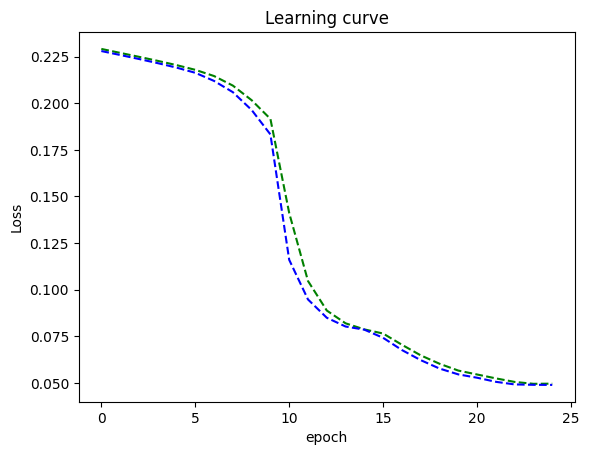

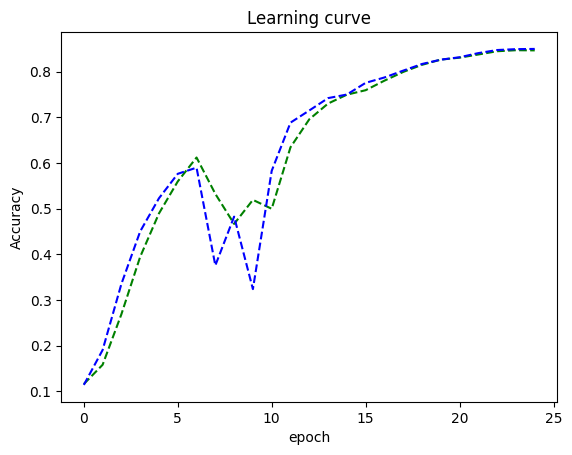

In [68]:
fig = plt.subplots()
plt.plot(clf.log_loss, 'g--')
plt.plot(clf.log_loss_val, 'b--')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Learning curve')
plt.show()

fig = plt.subplots()
plt.plot(clf.log_acc, 'g--')
plt.plot(clf.log_acc_val, 'b--')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title('Learning curve')
plt.show()